# <center>Generating Music Using LSTM Cells</center>



In [13]:
# Imports
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, History

This function will get the notes from all midi files

In [5]:
def get_notes():
    """ Get all the notes and chords from the midi files """
    notes = []

    for file in glob.glob("Pokemon MIDIs/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        # Grabs notes from midi files
        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            
        # Parses by grabbing notes as integers representing pitch (dot separated for chords)
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

In [6]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    # reshape the input into a format compatible with LSTM layers
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input between 0 and 1
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [7]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(CuDNNLSTM(512,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(CuDNNLSTM(512, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(CuDNNLSTM(512)))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

In [8]:
def generate_notes(model, notes, network_input, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    pitchnames = sorted(set(item for item in notes))
    
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = np.append(pattern,index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [9]:
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

In [10]:
def train_network():
    """ Train a Neural Network to generate music """
    # Get notes from midi files
    notes = get_notes()

    # Get the number of pitch names
    n_vocab = len(set(notes))

    # Convert notes into numerical input
    network_input, network_output = prepare_sequences(notes, n_vocab)

    # Set up the model
    model = create_network(network_input, n_vocab)
    history = History()
    
    # Fit the model
    n_epochs = 2
    model.summary()
    model.fit(network_input, network_output, callbacks=[history], epochs=n_epochs, batch_size=64)
    model.save('LSTMmodel.h5')
    
    # Use the model to generate a midi
    prediction_output = generate_notes(model, notes, network_input, len(set(notes)))
    create_midi(prediction_output, 'pokemon_midi')
    
    # Plot the model losses
    pd.DataFrame(history.history).plot()
    plt.savefig('LSTM_Loss_per_Epoch.png', transparent=True)
    plt.close()

Parsing Pokemon MIDIs\Pokemon - Farewell, Pikachu!.mid
Parsing Pokemon MIDIs\Pokemon - Lavender town.mid
Parsing Pokemon MIDIs\Pokemon - Littleroot Town.mid
Parsing Pokemon MIDIs\Pokemon - Lugias Song.mid
Parsing Pokemon MIDIs\Pokemon - Oracion.mid
Parsing Pokemon MIDIs\Pokemon - Pallet Town.mid
Parsing Pokemon MIDIs\Pokemon - Pkmn Elite 4.mid
Parsing Pokemon MIDIs\Pokemon - pokecentre theme.mid
Parsing Pokemon MIDIs\Pokemon - Pokemon Center Theme.mid
Parsing Pokemon MIDIs\Pokemon - Pokemon Center.mid
Parsing Pokemon MIDIs\Pokemon - Pokemon Johto - Opening.mid
Parsing Pokemon MIDIs\Pokemon - The Ghost at Maiden's Peak.mid
Parsing Pokemon MIDIs\Pokemon Black & White - Village Bridge.mid
Parsing Pokemon MIDIs\Pokemon Black 2White 2 - Cave of Being.mid
Parsing Pokemon MIDIs\Pokemon Black 2White 2 - Join Avenue  Greeting.mid
Parsing Pokemon MIDIs\Pokemon Black 2White 2 - Ns Room.mid
Parsing Pokemon MIDIs\Pokemon Black 2White 2 - Ns Theme.mid
Parsing Pokemon MIDIs\Pokemon Black 2White 2 - T

Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - National Park.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - New Bark Town.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Olivine Lighthouse.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Pokemon Lullaby.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Pokemon March.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Professor Elms Lab.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Professor Oaks Theme.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Rival Battle.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Route 27.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Route 29.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Route 32.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Route 38.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Route 42.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Saffron City.mid
Parsing Pokemon MIDIs\Pokemon GoldSilverCrystal - Show M

Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Game Corner Theme.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Gym Leader Battle.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Gym.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Hall of Fame.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Indigo Plateau.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Intro 1.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Intro 2.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Jigglypuffs Song.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Lavender Town.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Mt Moon.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Oaks Lab.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Opening Yellow.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Pallet Town.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Pokemon Center.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Pokemon Tower.mid
Parsing Pokemon MIDIs\Pokemon RedBlueYellow - Printer Error.mi

W0910 09:49:13.293147  2656 deprecation_wrapper.py:119] From C:\Users\Michael\Anaconda3\envs\CITS4404\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 09:49:13.333382  2656 deprecation_wrapper.py:119] From C:\Users\Michael\Anaconda3\envs\CITS4404\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 09:49:15.792872  2656 deprecation_wrapper.py:119] From C:\Users\Michael\Anaconda3\envs\CITS4404\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0910 09:49:16.131791  2656 deprecation_wrapper.py:119] From C:\Users\Michael\Anaconda3\envs\CITS4404\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 512)          1054720   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1024)         4202496   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 1024)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6299648   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

NameError: name 'plt' is not defined

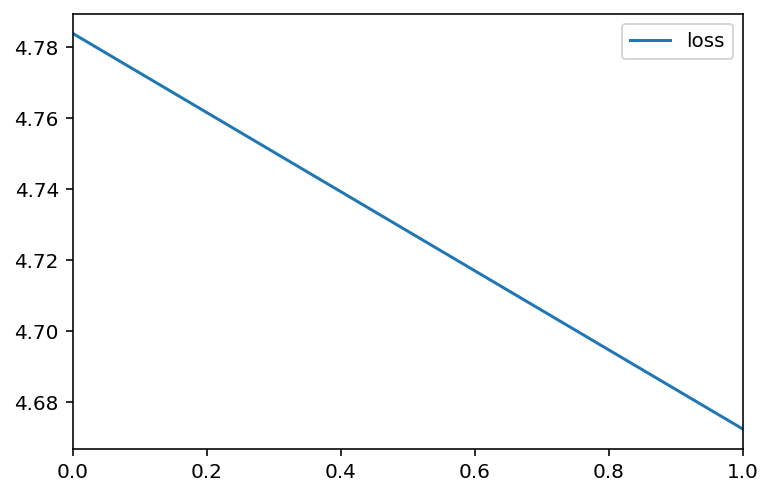

In [12]:
train_network()

In [14]:
model

NameError: name 'model' is not defined